# Add Folders to Path

In [ ]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add Algorithm folder to current working path in order to access the functions
sys.path.append(parent_directory+"/Src")

In [1]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

Wall time: 0 ns


# Overview

In the following notebok we visualize elliptic LCS in the Agulhas region from the AVISO dataset by means of the lagrangian single trajectory rotation diagnostics TRA (= Trajectory Rotation Angle). The notebook is structured as follows:

* Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'
* Define computational parameters (such as the number of cores to be used for parallel computing) and variables
* Define spatio-temporal domain over which to compute the hyperbolic LCS. The spatial domain defines the meshgrid from where to launch the trajectories and the temporal domain specifies the time-interval (in days).
* Interpolate velocity from the gridded velocity data using cubic spline interpolation.
* Compute trajectories and velocity along trajectories over meshgrid of initial conditions over the specified time-interval
* Compute TRA for each trajectory.

# AVISO Data from Agulhas Region

In [1]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 282 ms, sys: 65.1 ms, total: 347 ms
Wall time: 346 ms


# Data/Parameters for Dynamical System

In [3]:
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 8

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, "Periodic": Periodic}

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
# Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Initial time (in days)
t0 = 25

# Final time (in days)
tN = 40

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 5
ymin = -35
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *

DS = Dynamical_System(params_data, params_DS)

Wall time: 290 ms


## Velocity Interpolation

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

Wall time: 76.8 ms


## Trajectory/Velocity  Computation

Trajectories are launched from the grid of initial conditions specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 14-17)**.
The temporal domain as well as the time resolution is also indicated in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 2-11)**.

In [6]:
%%time
from joblib import Parallel, delayed

def parallel(i):

    velocity_grid_ = np.zeros((X_domain.shape[1], 2, len(time)-1))
    
    for j in range(X_domain.shape[1]):
        
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        velocity_grid_[j, :, :] = DS._trajectory(x, time)[1]
        
    return velocity_grid_

velocity_grid = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/251 [00:00<?, ?it/s]

Wall time: 3min 28s


## Spatio-Temporal Average of Velocity

The characteristic velocity $ \mathrm{v_0} $ is estimated by taking the spatio-temporal derivative of the velocity-field of the trajectories launched from the meshgrid over the time-interval $ [t_0, t_N] $.

In [7]:
v0 = np.nanmean(np.sqrt(velocity_grid[:,:,0,:]**2+velocity_grid[:,:,1,:]**2))

## Trajectory Rotation Average ($ \mathrm{\overline{TRA}}$)

In [8]:
from ipynb.fs.defs.TRA import _TRA
TRA = _TRA(tN-t0, velocity_grid, v0)

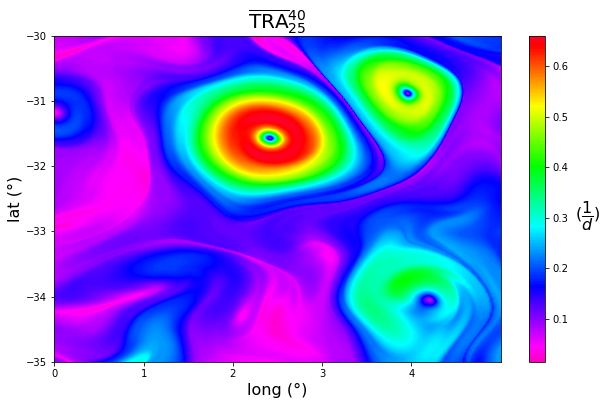

In [11]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axis
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, TRA, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .7, 8))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 20, fontsize = 16)

# Title
ax.set_title(r'$ \mathrm{\overline{TRA}}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 20)

plt.show()